In [0]:
#@title GPU define
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 18 13:41:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#@title Import data from google drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict
import matplotlib as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driver = GoogleDrive(gauth)

downloaded = driver.CreateFile({'id':'1X97dcpmWKOzXp6-YBAB42DL1zzeCBwIQ'})
downloaded.GetContentFile('train_abstracts.csv')

downloaded = driver.CreateFile({'id':'1jpa95rMM-9TxfUCg9dKZbjAL-qv6wOx2'})
downloaded.GetContentFile('train_relations.csv')

downloaded = driver.CreateFile({'id':'1oasiLvRk281QSCeZ6orbxvfESqbU1kZD'})
downloaded.GetContentFile('training_entities.csv')

downloaded = driver.CreateFile({'id':'1Vj3SV7V1wEhIsU1LgwlmqPpTfTKib_xk'})
downloaded.GetContentFile('glove.6B.50d.txt')


from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#@title Hyperparameters
MAX_SNET_LENGTH = 50
EMBEDDING_DIM = 50


## Import Data
Input: train_abstracts = [ID][Title][Abstract] = [1020 x 3]

Output: train_relations = [ID][CPR][Eval][Type][Arg1][Arg2] = [6437 x 6]


In [0]:
#@title Load files
import pandas as pd
import numpy as np
train_abstracts = pd.read_csv("train_abstracts.csv")
train_relations = pd.read_csv("train_relations.csv")
train_entities = pd.read_csv('training_entities.csv')

In [10]:
print(train_relations)
print(relations_all)

            ID    CPR Eval                  Type      Arg1      Arg2
0     10047461  CPR:3   Y              ACTIVATOR  Arg1:T13  Arg2:T57
1     10047461  CPR:3   Y              ACTIVATOR   Arg1:T7  Arg2:T39
2     10047461  CPR:3   Y              ACTIVATOR   Arg1:T7  Arg2:T40
3     10047461  CPR:3   Y              ACTIVATOR   Arg1:T7  Arg2:T41
4     10047461  CPR:3   Y   INDIRECT-UPREGULATOR  Arg1:T13  Arg2:T55
...        ...    ...  ...                   ...       ...       ...
6432   9928259  CPR:6   Y             ANTAGONIST  Arg1:T15  Arg2:T24
6433   9928259  CPR:9   Y              SUBSTRATE  Arg1:T14  Arg2:T22
6434   9928259  CPR:9   Y              SUBSTRATE  Arg1:T14  Arg2:T23
6435   9928259  CPR:9   Y              SUBSTRATE   Arg1:T1  Arg2:T21
6436   9928259  CPR:9   Y              SUBSTRATE   Arg1:T1  Arg2:T25

[6437 rows x 6 columns]
            ID CPR  ...                   Arg2_Name Type_Label
1237   1332478   4  ...  beta 2-adrenergic receptor          8
1245   1361547   6  .

In [0]:
#@title Label CPR for Title
abstracts_sort = train_abstracts[['ID','Title']].sort_values(by=['ID'])
relations_sort = train_relations[['ID','CPR']].sort_values(by=['ID'])
relations_sort['CPR'] = relations_sort['CPR'].map(lambda x: x.lstrip('CPR:'))
def OneHotLabel(abstracts, CPR):
  labels = torch.zeros(len(abstracts),10)
  count = 0
  for index in range(len(abstracts)):
    ID = abstracts.iat[index,0]
    while ID == CPR.iat[count,0]:
      labels[index, int(CPR.iat[count,1])-1] = 1   # assign label
      if count < len(CPR)-1:
        count += 1 
      else:
        break
  return labels
labels = OneHotLabel(abstracts_sort,relations_sort)

In [9]:
print(Chem_dict)
print(Gene_dict)

                                             Name
0                        (+)- and (-)- tamsulosin
1                         (+)- and (-)-tamsulosin
2     (+)-[2-125i] iodolysergic acid diethylamide
3                                 (+)-amphetamine
4                             (+)-methamphetamine
...                                           ...
3250                                  γ-terpinene
3251                    δ(9)-tetrahydrocannabinol
3252                                         δcor
3253                                        δdhea
3254                                          NaN

[3255 rows x 1 columns]
                                                   Name
0                                     (125)i-tyr(4)-bbn
1                                             (ct((a)))
2     (hepatocyte growth factor activator inhibitor)...
3                                                (il)-4
4                                                (nf-κb
...                                    

In [7]:
#@title Chemical-Gene Dictionary
Chem_Gene = train_entities[['Type','Name']]    # Extract 'type' and 'name' colum
Chem_Gene['Type'] = Chem_Gene['Type'].map(lambda x: x.rstrip('-N-Y'))    # strip -N and -Y
Chem_Gene['Name'] = Chem_Gene['Name'].str.lower()     # lowercase for Name
Chem = Chem_Gene.loc[Chem_Gene['Type']=='CHEMICAL']   # Extract chemicals
Gene = Chem_Gene.loc[Chem_Gene['Type']=='GENE']   # Extract chemicals
Chem_dict = pd.DataFrame(Chem.Name.sort_values().unique())   # find unique Chemical
Gene_dict = pd.DataFrame(Gene.Name.sort_values().unique())   # find unique Gene
Chem_dict.columns=['Name']     # Chem dictionary
Gene_dict.columns=['Name']     # Gene dictionary

# Generate entities and relations
entities_all = train_entities.sort_values(by=['ID'])
relations_all = train_relations.sort_values(by=['ID'])
relations_all['Arg1'] = relations_all['Arg1'].map(lambda x: x.lstrip('Arg1:'))   # strip 'Arg1:'
relations_all['Arg2'] = relations_all['Arg2'].map(lambda x: x.lstrip('Arg2:'))   # strip 'Arg2:'
relations_all['CPR'] = relations_all['CPR'].map(lambda x: x.lstrip('CPR:'))      # strip 'CPR:'
relations_all['Arg1_Name']=""
relations_all['Arg2_Name']=""
relations_all['Type_Label']=""
relations_uniqueID = pd.unique(relations_all.ID.sort_values())        # create unique ID relations sort by ID
relations_uniqueType = pd.unique(relations_all.Type.sort_values())    # create unique type relations sort by type

for i, word in enumerate(relations_uniqueType):
  relations_all['Type_Label'][relations_all.Type==word] = i           # label type 

# Preallocation CPR and Gene Map
Chem_Gene_CPR = np.zeros((len(Chem_dict),len(Gene_dict)))
Chem_Gene_Type = np.zeros((len(Chem_dict),len(Gene_dict))) 

for i, number in enumerate(relations_uniqueID):
  relations_section = relations_all.loc[relations_all['ID']==number]
  entities_section = entities_all.loc[entities_all['ID']==number]
  for j,index in enumerate(relations_section.index):
    Arg1 = relations_section.loc[index]['Arg1']
    Arg2 = relations_section.loc[index]['Arg2']
    chem = entities_section['Name'][entities_section.Label==Arg1].item().lower()
    gene = entities_section['Name'][entities_section.Label==Arg2].item().lower()
    relations_all.loc[index,'Arg1_Name'] = chem
    relations_all.loc[index,'Arg2_Name'] = gene
    chem_index = Chem_dict['Name'][Chem_dict.Name==chem].index.tolist()
    gene_index = Gene_dict['Name'][Gene_dict.Name==gene].index.tolist()
    CPR_index = relations_section.loc[index]['CPR']
    Type_index = relations_section.loc[index]['Type_Label']
    Chem_Gene_CPR[chem_index, gene_index] = CPR_index
    Chem_Gene_Type[chem_index, gene_index] = Type_index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

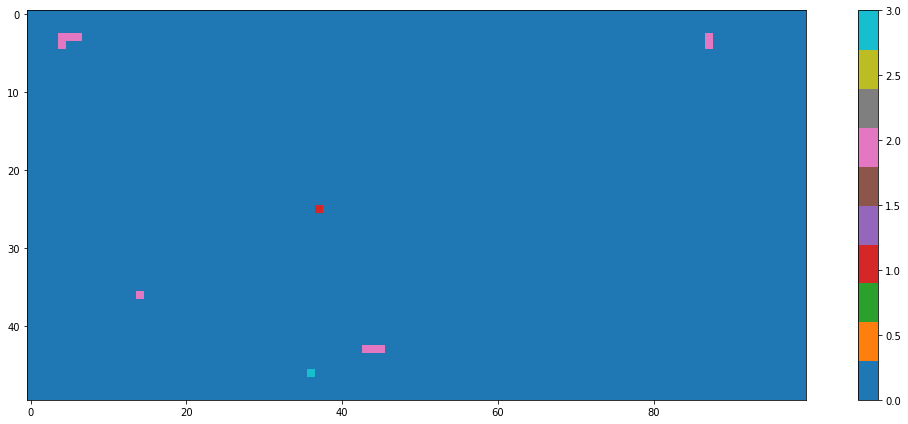

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(frameon=False,figsize=(15,6))

plt.imshow(Chem_Gene_CPR[850:900,950:1050], cmap='tab10')

plt.colorbar()

plt.tight_layout()
plt.show()

## Import GloVe 

Use pretrained GloVe 6B-50d to embeded words
* 

In [0]:
#@title GloVe Embedding
class Word_Embedding():
  def __init__(self, file, max_sent_length = MAX_SNET_LENGTH, embedding_dim=EMBEDDING_DIM):
    self.max_sent_length = max_sent_length
    self.embedding_dim = embedding_dim
    self.embeddings_dict = {}
    self.embeddings_index = {}
    self.word2vec = torch.zeros(max_sent_length, embedding_dim)   # pre-allocation

    from nltk.tokenize import TreebankWordTokenizer
    self.tokenizer = TreebankWordTokenizer()
    with open(file, 'r') as f:
        count = 0 
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            self.embeddings_dict[word] = vector
            self.embeddings_index[word] = count
            count += 1

  def get_embedding_vec(self, word):
    idx = self.embeddings_index.get(word.lower(), -1)           
    if idx == -1:
        return np.zeros((self.embedding_dim, ), dtype='float32')     
    return self.embeddings_dict[word.lower()]

  def sent_embedding(self, sentence):
    sent = self.tokenizer.tokenize(sentence)          # sentence split into words 
    for i, word in enumerate(sent): 
      vector = self.get_embedding_vec(word)           # get vector from dict
      self.word2vec[i] = torch.from_numpy(vector)                 
    return self.word2vec

  def batch_embedding(self, data, column):          
    batch2vec = torch.zeros(len(data), self.max_sent_length, self.embedding_dim)
    for i in range(len(data)):
      sent = data.iat[i,column]
      vectors = self.sent_embedding(sent)
      batch2vec[i] = vectors
    return batch2vec

word_embedding = Word_Embedding('glove.6B.50d.txt')
dataset = word_embedding.batch_embedding(train_abstracts, column=1)

In [0]:
#@title Split dataset into train and validation

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data

class RPDataset(data.Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)
  def __getitem__(self, index):
    inputs = self.x[index]
    outputs = self.y[index]
    return inputs.to(device), outputs.to(device)

# Creating data indices for training and validation splits:
batch_size = 50
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

x_train = dataset[train_indices]
y_train = labels[train_indices]
x_valid = dataset[val_indices]
y_valid = labels[val_indices]

# # Creating PT data samplers and loaders:
train_set = RPDataset(x_train, y_train)
val_set = RPDataset(x_valid, y_valid)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=True)

In [0]:
#@title Training data
class Title_Classifer(nn.Module):
  def __init__(self, embed_size, hidden_size, num_layer=2, dropout=0.5, num_class=10):
    super(Title_Classifer, self).__init__()

    self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layer,
                      batch_first=True, dropout=dropout, bidirectional=True)
    self.reduction = nn.Linear(num_layer*2, 1) 
    self.classifer = nn.Linear(hidden_size, num_class)
  
  def forward(self, input):
    """
    input: [batch, length, hidden]
    hidden: [batch, num_layer*directions, hidden]
    output: [batch, Length, Hidden*direction]
    finals: [num_layer*directions, batch, hidden]    
    """
    input = input.to(device)
    outputs, finals = self.gru(input)
    dense = self.reduction(finals.permute(1,2,0))
    out_class = self.classifer(dense.squeeze(2))    
    return out_class 


from sklearn.metrics import precision_recall_fscore_support
class LossComputes:
  def __init__(self, model, clip, opt=None):
    self.clip = clip
    self.opt = opt
    self.model = model
    self.mse = nn.MSELoss()
    self.sig = nn.Sigmoid()
    self.CE = nn.CrossEntropyLoss()
    self.BCE = nn.BCEWithLogitsLoss()

  def accuracy(self, pred, truth):
    with torch.no_grad(): 
      pred = self.sig(pred).cpu()
      truth = truth.cpu()
      p, r, f1, _ = precision_recall_fscore_support(truth <0.5, pred < 0.5, average="samples", zero_division=0)
    return p, r, f1

  def __call__(self, pred, truth):

    loss_BCE = self.BCE(pred, truth)
    p,r,f1 = self.accuracy(pred, truth)
    loss = loss_BCE

    if self.opt is not None:
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
      self.opt.step()
      self.opt.zero_grad()
    return loss.data.item(), p, r, f1


def run_epoch(data_loader, model, loss_compute, print_every):
  total_loss = 0

  for i, (inputs, truth) in enumerate(data_loader):
    pred = model(inputs)
    loss, p, r, f1 = loss_compute(pred, truth)  
    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss:%f  Precision:%f  Recall:%f  Score:%f" % (i, loss, p, r, f1))
  return loss, f1

def train(model, num_epochs, learning_rate, print_every=10, clip=2):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  train_losses = []
  valid_losses = []
  train_f1s = []
  valid_f1s = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    train_loss, train_f1 = run_epoch(data_loader=train_loader, model=model,
                          loss_compute=LossComputes(model, clip, optim),
                          print_every=print_every)
    model.eval()
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    with torch.no_grad():      
      valid_loss, valid_f1 = run_epoch(data_loader=valid_loader, model=model,
                          loss_compute=LossComputes(model, clip, opt=None),
                          print_every=print_every)
      print("Val Determination: %f %f" % (valid_loss, valid_f1))
      valid_losses.append(valid_loss)
      valid_f1s.append(valid_f1)

      # if valid_loss < threshold:
      #   model_save_name = '7-90_class_BCE.pt'
      #   path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
      #   torch.save(denseNet.state_dict(), path)
      #   print('Model Save! threshold: %f' % valid_R2)
      #   threshold = valid_loss
      # else:
      #   continue

  train_f1s = torch.FloatTensor(train_f1s)     
  valid_f1s = torch.FloatTensor(valid_f1s) 
  print('The Best f1 %f' % torch.max(valid_f1s))
  return train_f1s, valid_f1s

NUM_EPOCHS = 30
LEARN_RATE = 1e-4

title_gru = Title_Classifer(50, 150).to(device)
train_f1s, valid_f1s = train(title_gru, NUM_EPOCHS, LEARN_RATE)


Epoch 0
Epoch Step: 0 Loss:0.691155  Precision:0.885532  Recall:0.553135  Score:0.665141
Epoch Step: 10 Loss:0.664150  Precision:0.855516  Recall:0.815278  Score:0.826567
Val Determination: 0.643940 0.821487
Epoch 1
Epoch Step: 0 Loss:0.647550  Precision:0.833810  Recall:0.896071  Score:0.858497
Epoch Step: 10 Loss:0.619191  Precision:0.843111  Recall:0.986556  Score:0.905038
Val Determination: 0.574237 0.936842
Epoch 2
Epoch Step: 0 Loss:0.585561  Precision:0.868000  Recall:0.993000  Score:0.922159
Epoch Step: 10 Loss:0.543223  Precision:0.850000  Recall:1.000000  Score:0.913707
Val Determination: 0.508217 0.870829
Epoch 3
Epoch Step: 0 Loss:0.514960  Precision:0.840000  Recall:1.000000  Score:0.908256
Epoch Step: 10 Loss:0.456850  Precision:0.840000  Recall:1.000000  Score:0.908419
Val Determination: 0.461185 0.868787
Epoch 4
Epoch Step: 0 Loss:0.380290  Precision:0.876000  Recall:1.000000  Score:0.930803
Epoch Step: 10 Loss:0.367699  Precision:0.862000  Recall:1.000000  Score:0.9217

In [0]:
print('database',database.shape)
print('output',out_class.shape)
# print('finals',finals.shape)


database torch.Size([1020, 50, 50])
output torch.Size([1020, 10])


In [0]:
# import nltk
# nltk.download('punkt')
# text = train_abstract.iat[3,2]
# sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
# result = sentence_splitter.tokenize(text)

# from nltk.tokenize import TreebankWordTokenizer
# tokenizer = TreebankWordTokenizer()
# result2 = tokenizer.tokenize(result[1])

# print(result)
# print(result2)